In [1]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('../Training Data.csv', low_memory = False)
val_data = pd.read_csv('../Validation Data.csv', low_memory = False)
print(train_data.shape)
print(val_data.shape)

(6996, 1071)
(779, 1071)


In [3]:
# X = np.array(data_full.drop(labels = 'y', axis = 1))
X_train = np.array(train_data.drop(labels = 'y', axis = 1))
X_test = np.array(val_data.drop(labels = 'y', axis = 1))
y_train = train_data['y']
y_test = val_data['y']
y_train_binary = np.zeros(len(y_train))
y_train_binary[y_train == 'BBB+'] = 1
y_test_binary = np.zeros(len(y_test))
y_test_binary[y_test == 'BBB+'] = 1

print(X_train.shape)
print(y_train_binary.shape)
print(X_test.shape)
print(y_test_binary.shape)

(6996, 1070)
(6996,)
(779, 1070)
(779,)


In [4]:
mm = MinMaxScaler()
mm.fit(X_train)
Xs_train = mm.fit_transform(X_train)
print(Xs_train.shape)

(6996, 1070)


In [5]:
mm.fit(X_test)
Xs_test = mm.fit_transform(X_test)
print(Xs_test.shape)

(779, 1070)


In [6]:
print(y_train_binary.mean())
print(y_test_binary.mean())

0.634505431675243
0.6341463414634146


In [7]:
svm_lin = SVC(kernel='linear', probability=True)
svm_lin.fit(Xs_train, y_train_binary)

SVC(kernel='linear', probability=True)

In [8]:
thresh = 0.3
y_probs = svm_lin.predict_proba(Xs_test)
# y_preds = svm_lin.predict(Xs_test)
y_preds = np.where(y_probs[:,1]>thresh,1,0)

In [9]:
y_probs

array([[0.77944243, 0.22055757],
       [0.62767445, 0.37232555],
       [0.17974491, 0.82025509],
       ...,
       [0.90629981, 0.09370019],
       [0.89820297, 0.10179703],
       [0.75406431, 0.24593569]])

In [10]:
accuracy_score(y_test_binary, y_preds)

0.8664955070603337

In [11]:
cm = confusion_matrix(y_test_binary, y_preds)
print(cm)

[[218  67]
 [ 37 457]]


In [12]:
tp_own = np.sum(np.logical_and(y_test_binary == 1, y_preds == 1).astype(int))
fp_own = np.sum(np.logical_and(y_test_binary == 0, y_preds == 1).astype(int))
fn_own = np.sum(np.logical_and(y_test_binary == 1, y_preds == 0).astype(int))
tn_own = np.sum(np.logical_and(y_test_binary == 0, y_preds == 0).astype(int))
print('TP:{}'.format(tp_own))
print('FN:{}'.format(fn_own))
print('FP:{}'.format(fp_own))
print('TN:{}'.format(tn_own))

TP:457
FN:37
FP:67
TN:218


In [13]:
tn,fp,fn,tp = cm.ravel()
print('TP:{}'.format(tp))
print('FN:{}'.format(fn))
print('FP:{}'.format(fp))
print('TN:{}'.format(tn))

TP:457
FN:37
FP:67
TN:218


In [14]:
print(tp/(tp+fn))
print(fp/(fp+tn))

0.9251012145748988
0.23508771929824562


In [15]:
svm_lin.classes_

array([0., 1.])

In [68]:
rs = 42
thresh = 0.3
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=rs)
f = []
tpr= []
fpr = []
for train_id, test_id in tqdm(skf.split(Xs_train, y_train_binary)):
    Xs_train_k, Xs_test_k = Xs_train[train_id], Xs_train[test_id]
    y_train_k, y_test_k = y_train_binary[train_id], y_train_binary[test_id]
    
    svm_lin.fit(Xs_train_k, y_train_k)
    probs = svm_lin.predict_proba(Xs_test_k)
    y_pred = np.where(probs[:,1] > thresh, 1, 0)
    f.append(f1_score(y_test_k, y_pred))
    tn,fp,fn,tp = confusion_matrix(y_test_k, y_pred).ravel()
    tpr.append(tp/(tp+fn))
    fpr.append(fp/(fp+tn))
f = np.array(f)

5it [04:47, 57.45s/it]


In [69]:
f

array([0.8865656 , 0.89014374, 0.87905301, 0.88682171, 0.89015544])

In [70]:
f.mean()

0.8865478995157879

In [71]:
print(tpr)

[0.954954954954955, 0.9763513513513513, 0.9617117117117117, 0.9662162162162162, 0.9684329199549042]


In [72]:
print(fpr)

[0.345703125, 0.3776908023483366, 0.3933463796477495, 0.3698630136986301, 0.359375]


In [18]:
res = np.array([f.mean()]+fpr+tpr)
print(len(res))

11


In [16]:
rs = 42
def f_kcv(thresh):
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=rs)
    f = []
    tpr = []
    fpr = []
    print('Computing f_score for threshold:{}'.format(thresh))
    for train_id, test_id in tqdm(skf.split(Xs_train, y_train_binary)):
        Xs_train_k, Xs_test_k = Xs_train[train_id], Xs_train[test_id]
        y_train_k, y_test_k = y_train_binary[train_id], y_train_binary[test_id]

        svm_lin.fit(Xs_train_k, y_train_k)
        probs = svm_lin.predict_proba(Xs_test_k)
        y_pred = np.where(probs[:,1] > thresh, 1, 0)
        f.append(f1_score(y_test_k, y_pred))
        tn,fp,fn,tp = confusion_matrix(y_test_k, y_pred).ravel()
        tpr.append(tp/(tp+fn))
        fpr.append(fp/(fp+tn))
    f = np.array(f)
    return np.array([f.mean()] + fpr + tpr)

In [74]:
f_kcv(0.3)

Computing f_score for threshold:0.3


5it [05:10, 62.14s/it]


array([0.88673202, 0.33984375, 0.3776908 , 0.39334638, 0.36986301,
       0.36132812, 0.95382883, 0.97635135, 0.96058559, 0.96621622,
       0.97068771])

In [19]:
thresh_vals = np.arange(0.1, 1,0.05)
print(len(thresh_vals))
print(thresh_vals)

18
[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95]


In [20]:
res = [f_kcv(t) for t in thresh_vals]

Computing f_score for threshold:0.1


5it [04:51, 58.38s/it]


Computing f_score for threshold:0.15000000000000002


5it [05:12, 62.58s/it]


Computing f_score for threshold:0.20000000000000004


5it [04:50, 58.03s/it]


Computing f_score for threshold:0.25000000000000006


5it [03:23, 40.74s/it]


Computing f_score for threshold:0.30000000000000004


5it [03:22, 40.57s/it]


Computing f_score for threshold:0.3500000000000001


5it [03:33, 42.68s/it]


Computing f_score for threshold:0.40000000000000013


5it [03:29, 41.96s/it]


Computing f_score for threshold:0.45000000000000007


5it [03:22, 40.49s/it]


Computing f_score for threshold:0.5000000000000001


5it [03:28, 41.68s/it]


Computing f_score for threshold:0.5500000000000002


5it [03:12, 38.44s/it]


Computing f_score for threshold:0.6000000000000002


5it [03:13, 38.74s/it]


Computing f_score for threshold:0.6500000000000001


5it [03:12, 38.56s/it]


Computing f_score for threshold:0.7000000000000002


5it [03:22, 40.49s/it]


Computing f_score for threshold:0.7500000000000002


5it [03:27, 41.47s/it]


Computing f_score for threshold:0.8000000000000002


5it [03:54, 46.99s/it]


Computing f_score for threshold:0.8500000000000002


5it [04:06, 49.36s/it]


Computing f_score for threshold:0.9000000000000002


5it [04:50, 58.17s/it]


Computing f_score for threshold:0.9500000000000003


5it [04:13, 50.71s/it]


In [21]:
res = np.array(res)
print(res.shape)

(18, 11)


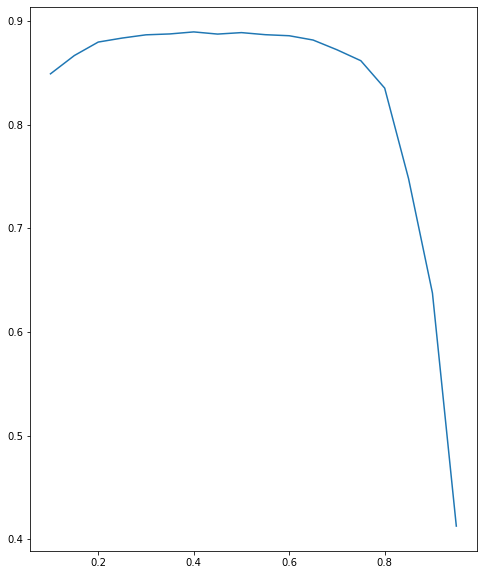

In [22]:
f_vec = res[:,0]
fig, axs = plt.subplots(nrows=1, ncols = 1, figsize = (8,10))
axs.plot(thresh_vals, f_vec)

In [23]:
f_vec

array([0.84916595, 0.86684288, 0.87983466, 0.88368922, 0.88682061,
       0.8876763 , 0.88963258, 0.88753636, 0.88895235, 0.8869485 ,
       0.88593229, 0.88179237, 0.87239304, 0.86183166, 0.83536239,
       0.74795373, 0.63760911, 0.41262716])

In [28]:
np.where(f_vec == np.max(f_vec))

(array([6], dtype=int64),)

In [29]:
thresh_vals[6]

0.40000000000000013

In [32]:
np.arange(1,6)

array([1, 2, 3, 4, 5])

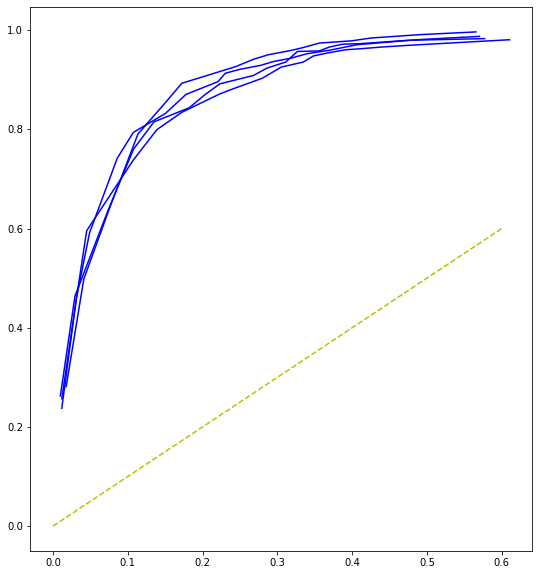

In [33]:
fig, axs = plt.subplots(nrows=1, ncols = 1, figsize = (9,10))
xs = np.arange(0,0.61,0.01)
for i in np.arange(1,5):
    axs.plot(res[:,i], res[:,i+5], color = 'b')
axs.plot(xs,xs,color = 'y', linestyle = '--')

In [34]:
fpr_, tpr_, _ = roc_curve(y_true=None, y_score=None, pos_label=None, fpr=res[:,1], tpr=res[:,6])

# Plot the ROC curve
plt.plot(fpr_, tpr_, 'b-', label='Approximate ROC curve')
plt.plot([0, 1], [0, 1], 'r--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

TypeError: roc_curve() got an unexpected keyword argument 'fpr'